In [2]:
# Cell 1: Sửa đổi
import networkx as nx
import numpy as np
from queue import PriorityQueue
import ipywidgets as widgets
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import logging
import dgl 
import os 
import random 
import itertools 

# Giả định utils.py chứa MỌI THỨ từ file Original.ipynb
# (MultiHeadDQN, NetworkEnv, ReplayBuffer, evaluate_model, v.v.)
from utils.attack_algo_utils import *
from utils.graph_utils import *
from utils.utils import *

# --- CUDA DEVICE SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Cell 2: (Sửa đổi)
import logging
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Configure logging to output to PyCharm's console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

def add_node_with_edges(graph, node_name):
    """
    Thêm một node vào đồ thị. 
    Giai đoạn 1: Cho phép người dùng nhập 'priority' cho node mới.
    Giai đoạn 2: Cho phép người dùng nhập các cạnh liên quan.
    """
    # Thêm node (chưa có thuộc tính)
    graph.add_node(node_name)
    
    # Khai báo các widget toàn cục cho hàm này
    global node_dropdown, user_text, root_text, direction_dropdown, output, priority_text_widget
    output = widgets.Output()

    # --- Giai đoạn 2: Logic thêm cạnh (Giữ nguyên) ---
    def add_edge(b):
        with output:
            # (Lấy priority đã lưu để hiển thị lại thông báo)
            current_priority = graph.nodes[node_name].get('priority', 'N/A')
            priority_msg = f"<b>Node:</b> '{node_name}' (Priority={current_priority}).<br><b>Adding Edges:</b>"
            
            clear_output(wait=True)
            display(HTML(priority_msg))
            logger.info(f"Add Edge button clicked for node '{node_name}'.")

            try:
                target_node = node_dropdown.value
                user_prob = float(user_text.value)
                root_prob = float(root_text.value)
                direction = direction_dropdown.value

                if not (0.0 <= user_prob <= 1.0 and 0.0 <= root_prob <= 1.0):
                    display(HTML("<b>Error:</b> Probabilities must be in the range [0.0, 1.0]. Please try again."))
                    logger.error(f"Invalid probabilities: user={user_prob}, root={root_prob}")
                    # Hiển thị lại widget nếu lỗi
                    display_widgets(priority_msg) 
                    return

                edge_info = f"Edge Info: user={user_prob}, root={root_prob}, direction={direction}"

                if direction == "To Target":
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{node_name}' to '{target_node}' ({edge_info})"
                elif direction == "From Target":
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{target_node}' to '{node_name}' ({edge_info})"
                else:  # Bidirectional
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Bidirectional edge between '{node_name}' and '{target_node}' ({edge_info})"

                display(HTML(f"<b>Notification:</b> {edge_msg} has been added."))
                logger.info(f"{edge_msg} has been added.")
                # Hiển thị lại widget cho cạnh tiếp theo
                display_widgets(priority_msg) 
            except ValueError:
                display(HTML("<b>Error:</b> Invalid input for probabilities. Please enter valid numbers."))
                logger.error("Invalid input for probabilities.")

    def stop_adding(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Finished adding edges for node '{node_name}'."))
            logger.info(f"Finished adding edges for node '{node_name}'.")

    def display_widgets(priority_msg):
        """Hàm hiển thị Giao diện Giai đoạn 2 (Thêm cạnh)"""
        with output:
            clear_output(wait=True)
            display(HTML(priority_msg)) # Hiển thị lại thông báo node và priority
            
            existing_nodes = list(graph.nodes())
            if not existing_nodes:
                display(HTML("<b>Warning:</b> No existing nodes in the graph."))
                logger.warning("No existing nodes in the graph.")
                return

            global node_dropdown, user_text, root_text, direction_dropdown
            node_dropdown = widgets.Dropdown(options=existing_nodes, description='Target Node:', disabled=False)
            user_text = widgets.FloatText(value=0.0, description='User Prob:', style={'description_width': 'initial'})
            root_text = widgets.FloatText(value=0.0, description='Root Prob:', style={'description_width': 'initial'})
            direction_dropdown = widgets.Dropdown(options=["To Target", "From Target", "Bidirectional"], description='Edge Direction:', disabled=False)
            add_button = widgets.Button(description="Add Edge")
            stop_button = widgets.Button(description="Stop")

            add_button.on_click(add_edge)
            stop_button.on_click(stop_adding)

            display(node_dropdown, user_text, root_text, direction_dropdown, add_button, stop_button)

    # --- Giai đoạn 1: Logic thêm Priority (Mới) ---
    def set_priority(b):
        """Xử lý việc gán priority và chuyển sang Giai đoạn 2"""
        with output:
            try:
                # Lấy giá trị float (hoặc int nếu bạn muốn)
                priority_value = float(priority_text_widget.value) 
                
                # Gán thuộc tính 'priority' cho node
                graph.nodes[node_name]['priority'] = priority_value
                
                msg = f"<b>Notification:</b> Node '{node_name}' added with priority={priority_value}."
                logger.info(f"Node '{node_name}' priority set to {priority_value}.")
                
                # Chuyển sang Giai đoạn 2 (Thêm cạnh)
                # Truyền thông báo mới vào display_widgets
                display_widgets(f"{msg}<br><b>Now adding edges:</b>")
                
            except ValueError:
                clear_output(wait=True)
                display(HTML("<b>Error:</b> Invalid priority. Please enter a valid number."))
                logger.error("Invalid input for priority.")
                # Thử lại Giai đoạn 1
                display_priority_widget() 

    def display_priority_widget():
        """Hàm hiển thị Giao diện Giai đoạn 1 (Thêm Priority)"""
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added."))
            display(HTML(f"<b>Please set priority for '{node_name}':</b>"))
            
            global priority_text_widget
            priority_text_widget = widgets.FloatText(
                value=0.0, # Giá trị priority mặc định
                description='Priority:',
                style={'description_width': 'initial'}
            )
            
            set_priority_button = widgets.Button(description="Set Priority & Add Edges")
            set_priority_button.on_click(set_priority)
            
            display(priority_text_widget, set_priority_button)

    # --- Khởi chạy ---
    # Bắt đầu bằng cách hiển thị Giai đoạn 1 (Thêm Priority)
    display(output)
    display_priority_widget()

In [4]:
G_1 = nx.DiGraph()
G_1.add_nodes_from(["Data Server", "Pad", "Web Server", "Host 1", "Host 2", "Host 3", "File Server", "Router"])
node_attributes = {
    "Data Server": {"state": 0, "priority": 2}, "Pad": {"state": 0, "priority": 1},
    "Web Server": {"state": 0, "priority": 1}, "Host 1": {"state": 0, "priority": 1},
    "Host 2": {"state": 0, "priority": 0}, "Host 3": {"state": 0, "priority": 0},
    "File Server": {"state": 0, "priority": 0}, "Router": {"state": 0, "priority": 2}
}
nx.set_node_attributes(G_1, node_attributes)
edges = [
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}), ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}), ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}), ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}), ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}), ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}), ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}), ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}), ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04}), ("Data Server", "File Server", {"user": 0.6, "root": 0.02}),
    ("Router", "Web Server", {"user": 0.9, "root": 0.9}), ("Web Server", "Router", {"user": 0.9, "root": 0.9}),
    ("Router", "Data Server", {"user": 0.9, "root": 0.1}), ("Data Server", "Router", {"user": 0.9, "root": 0.9}),
    ("Pad", "Router", {"user": 0.7, "root": 0.5}),
]
G_1.add_edges_from(edges)


G_new = G_1.copy()
add_node_with_edges(G_new, "New node")


Output()

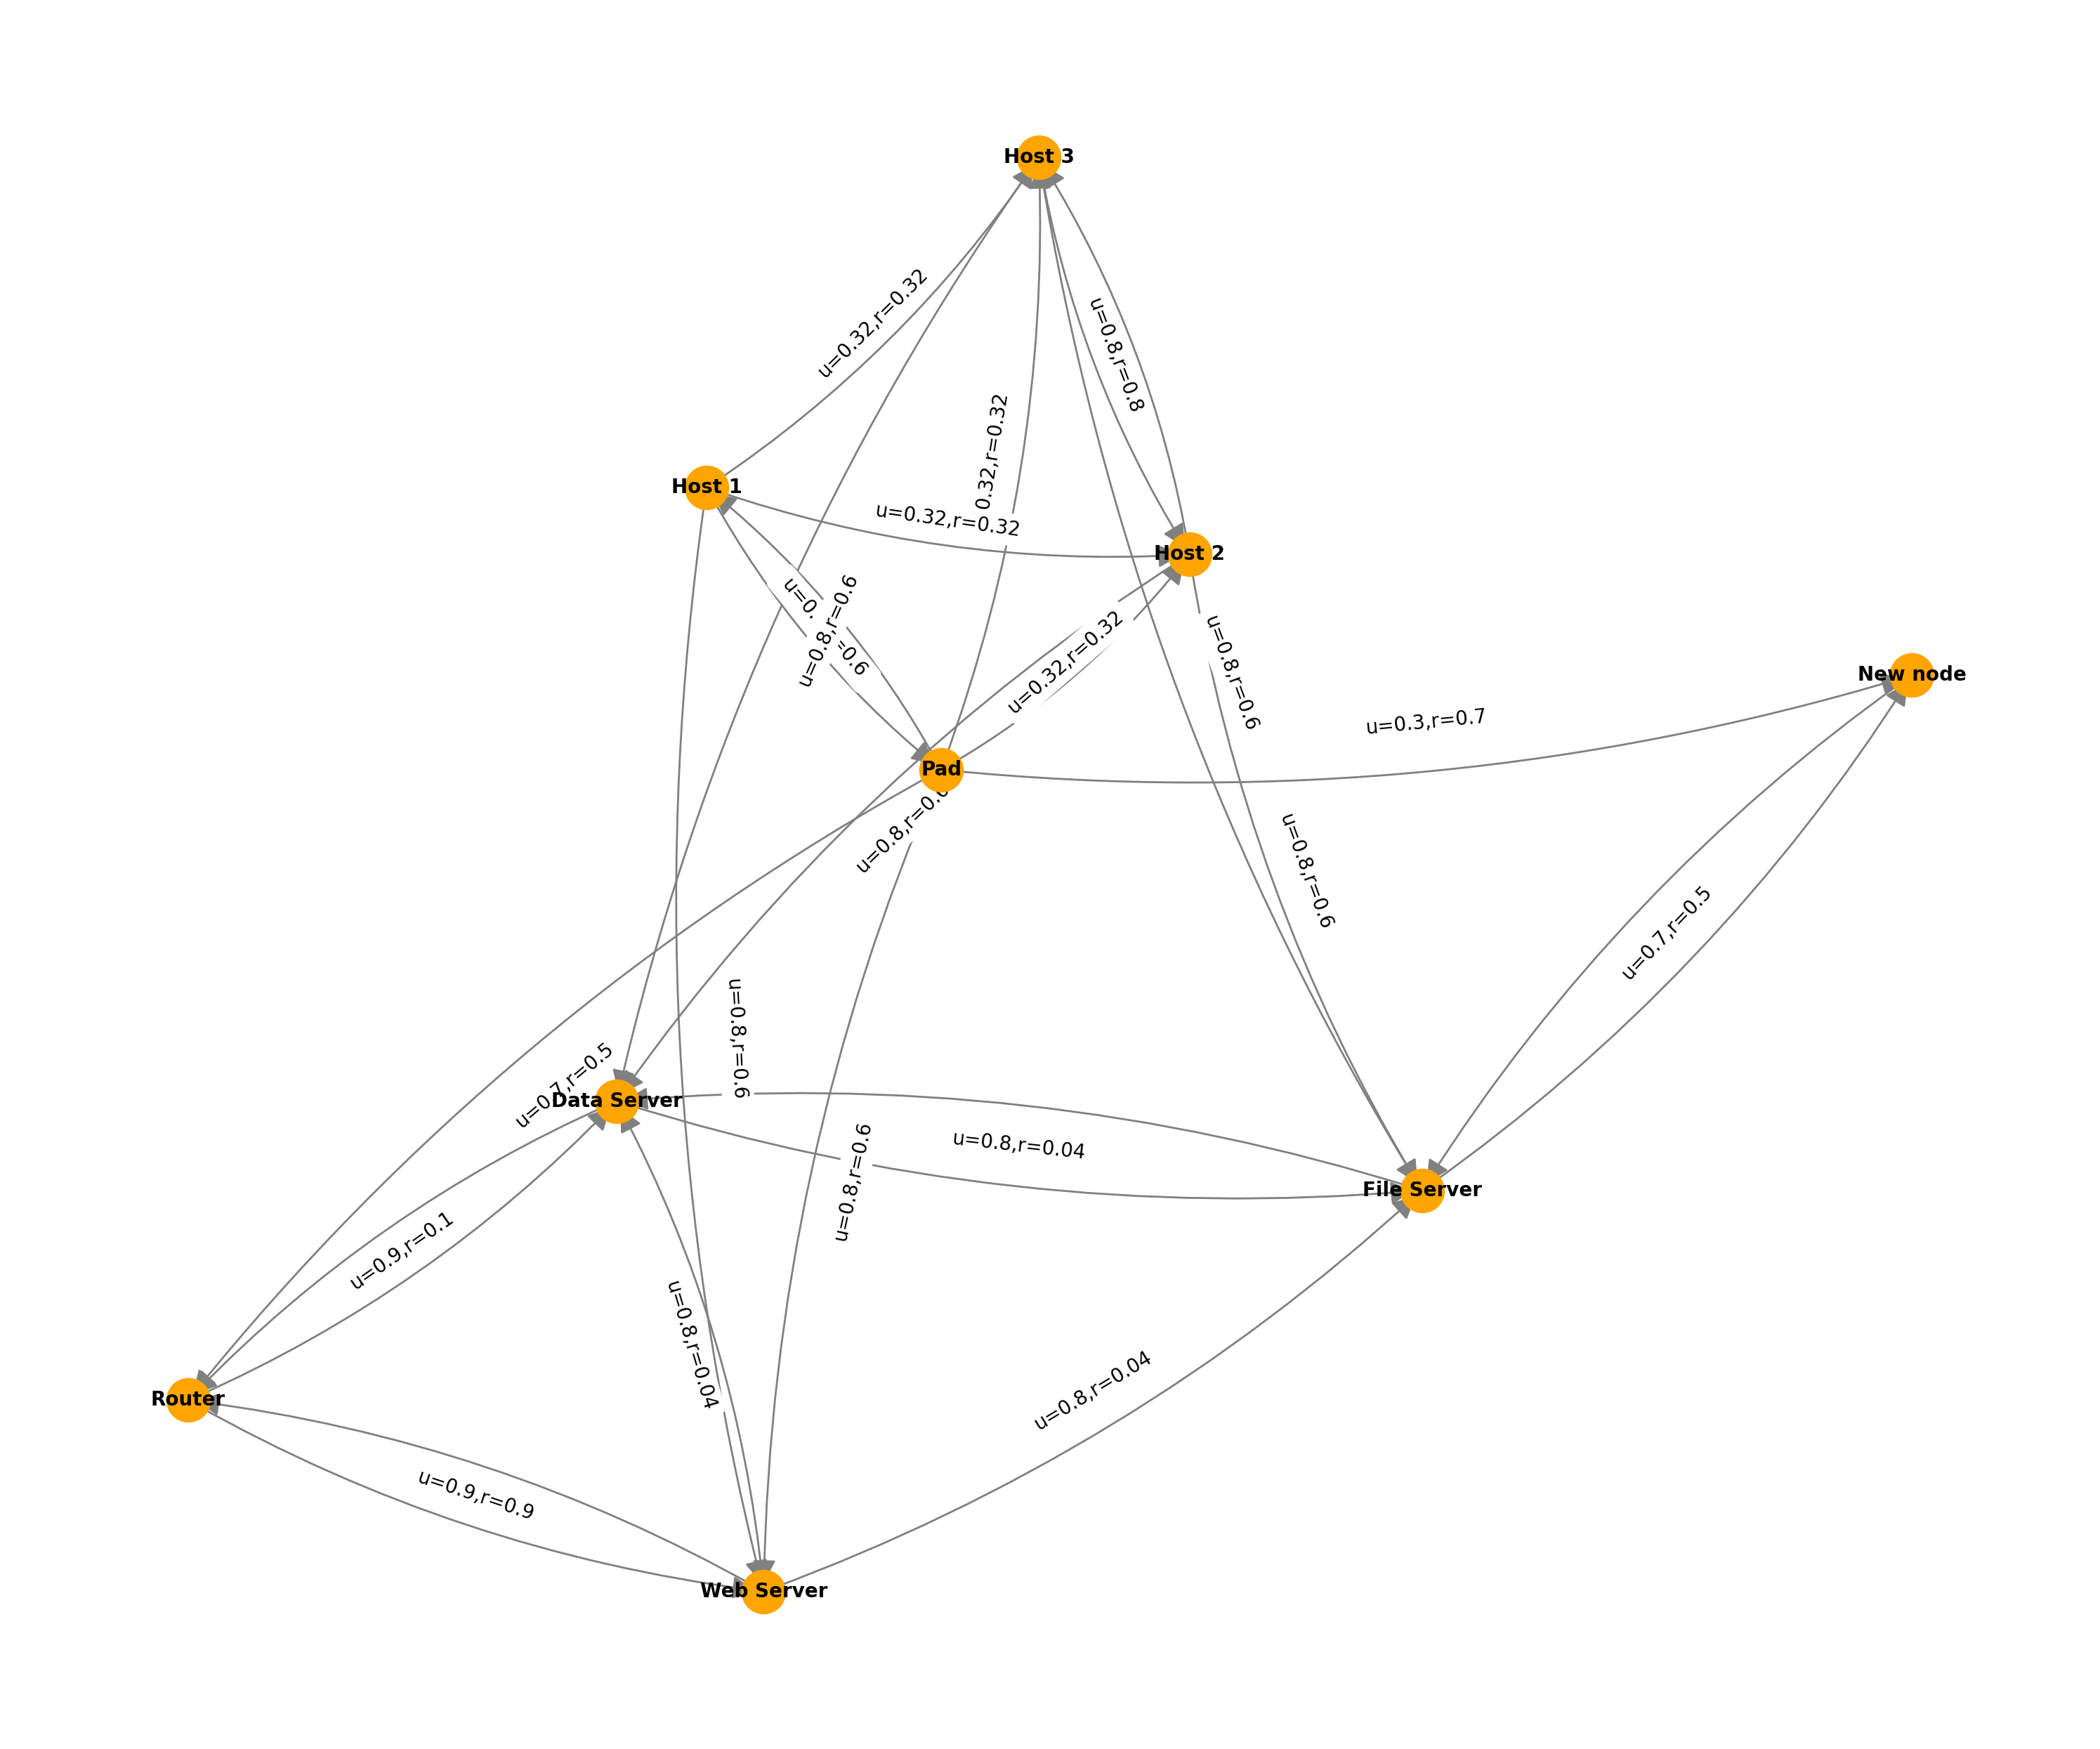

In [5]:
# Cell 4: (Giữ nguyên)
plt.figure(figsize=(30, 25))

# Cố định layout để lần nào cũng ra vị trí giống nhau
pos = nx.spring_layout(G_new, seed=42)

# Vẽ nodes
nx.draw_networkx_nodes(G_new, pos, node_color='orange', node_size=2000)

# Vẽ labels nodes
nx.draw_networkx_labels(G_new, pos, font_size=20, font_weight='bold')

# Vẽ edges với mũi tên và màu xám
nx.draw_networkx_edges(
    G_new, pos,
    edge_color='gray',
    arrows=True,
    arrowsize=50,
    width=2,
    connectionstyle='arc3,rad=0.1'  # Cạnh hơi cong cho đẹp
)

# Vẽ label trọng số cạnh
edge_labels = {(u, v): f"u={d['user']},r={d['root']}" for u, v, d in G_new.edges(data=True)}
nx.draw_networkx_edge_labels(G_new, pos, edge_labels=edge_labels, font_size=20)

plt.axis('off')
plt.tight_layout()

plt.savefig("graph_new.png") # Đổi tên file để không ghi đè
plt.show()


In [6]:
# Cell 5: (MỚI) Tải GNN Encoder (Giống Original.ipynb)
print("\n--- Đang tải cấu hình và trọng số GNN (Encoder tĩnh) ---")

BASE_PATH = 'graphs/1' # Phải khớp với file Original
MODEL_STATE_PATH = "graphs/dgi_model_state_dict.pth"
CONFIG_FILE_PATH = f"{BASE_PATH}/model_config.pth"
STATIC_ENV_PATH = f"{BASE_PATH}/graph_environment.pth"

try:
    # Tải cấu hình
    config = torch.load(CONFIG_FILE_PATH, weights_only=False)
    
    # Tải dữ liệu env tĩnh (để lấy feature gốc cho NetworkEnv)
    env_data = torch.load(STATIC_ENV_PATH, weights_only=False)
    original_node_features_static = env_data['node_features_original'].to(device)
    original_edge_features_static = env_data['edge_features_original'].to(device)
    g1_static = env_data['g1'].to(device)
    node_map_static = env_data['node_map']

    # Khởi tạo encoder rỗng
    encoder = EGraphSAGE_GraphAlign(
        config['NDIM_IN'],
        config['EDIM'],
        config['N_HIDDEN'],
        config['N_OUT'],
        config['N_LAYERS'],
        F.leaky_relu,
    )
    
    dgi_model_to_load = DGI_GraphAlign(encoder)
    dgi_model_to_load.load_state_dict(torch.load(MODEL_STATE_PATH, weights_only=False))
    
    # Trích xuất encoder đã huấn luyện
    trained_encoder = dgi_model_to_load.encoder
    trained_encoder.to(device)
    trained_encoder.eval()
    
    # Lấy kích thước embedding (ví dụ: 24)
    embedding_dim = config['N_OUT']

    print(f"[THÀNH CÔNG] Đã tải GNN encoder tĩnh.")

except Exception as e:
    print(f"\n[LỖI] Không thể tải GNN encoder tĩnh: {e}")
    trained_encoder = None


--- Đang tải cấu hình và trọng số GNN (Encoder tĩnh) ---
[THÀNH CÔNG] Đã tải GNN encoder tĩnh.


In [7]:
# Cell 6: (Thay thế Cell 5 cũ)
import torch
import torch.nn as nn

class MultiHeadDQNWithBias(nn.Module):
    """
    Wrapper mới cho MultiHeadDQN để áp dụng bias correction 
    khi mở rộng nút (incremental learning).
    """
    def __init__(self, base_model, old_honeypot_nodes_M, new_honeypot_nodes_M):
        super().__init__()
        self.model = base_model 
        
        self.old_M = old_honeypot_nodes_M
        self.new_M = new_honeypot_nodes_M
        
        if self.model.num_nodes_M != self.new_M:
            raise ValueError(f"Base model M ({self.model.num_nodes_M}) không khớp new_M ({self.new_M})")

        self.alpha = nn.Parameter(torch.Tensor([1.0]))
        self.beta = nn.Parameter(torch.Tensor([0.0]))

        print(f"MultiHeadDQNWithBias wrapper đã khởi tạo. Old M: {self.old_M}, New M: {self.new_M}")

    def forward(self, x):
        # q_raw shape: [batch_size, N, new_M]
        q_raw = self.model(x)

        # 1. Tách Q-values của các nút CŨ (slice theo chiều M)
        q_old = q_raw[:, :, :self.old_M]
        
        # 2. Tách Q-values của các nút MỚI
        q_new = q_raw[:, :, self.old_M:]

        # 3. Áp dụng correction CHỈ cho các nút MỚI
        q_new_corrected = self.alpha * q_new + self.beta

        # 4. Ghép chúng lại
        q_corrected = torch.cat([q_old, q_new_corrected], dim=2)
        
        return q_corrected

In [15]:
# Cell 7: (Thay thế Cell 6 cũ)
from copy import deepcopy
import dgl

# --- 1. Thiết lập Môi trường & Kích thước ---
N_honeypots = 3 
# (Lấy embedding_dim từ cell 5)
# embedding_dim = config['N_OUT'] 
target_priority = 2
goal_nodes = [
    node for node, data in G_1.nodes(data=True) 
    if 'priority' in data and data['priority'] == target_priority
]
# === Env CŨ (G_original) ===
# (Phần này giữ nguyên, dùng dữ liệu static đã tải ở Cell 5)
env_original = NetworkEnv(G_1, global_weighted_random_attack, g1_static, 
                          trained_encoder, original_node_features_static, 
                          original_edge_features_static, node_map_static, 
                          num_honeypots=N_honeypots, goal=goal_nodes)
old_num_nodes_state = env_original.num_nodes # (ví dụ: 8 nút)
M_old = env_original.num_honeypot_nodes      # (ví dụ: 8 nút có thể đặt)
state_size_old = old_num_nodes_state * embedding_dim # (ví dụ: 8 * 24 = 192)


# === Env MỚI (G_new) ===
# 1.1. Tạo bản sao G_new (NetworkX) và loại bỏ Attacker (nếu có)
G_new_nx = G_new.copy()


# 1.2. SỬA: Tạo node_map_new (Bảo toàn thứ tự cũ)
node_map_new = node_map_static.copy() # Bắt đầu bằng map cũ (8 nút)
new_nodes = []
current_idx = len(node_map_new)
for n in G_new_nx.nodes():
    if n not in node_map_new:
        node_map_new[n] = current_idx
        new_nodes.append(n) # (ví dụ: ["New node"])
        current_idx += 1

new_num_nodes_state = len(node_map_new) # (ví dụ: 9 nút)
M_new = new_num_nodes_state             # (ví dụ: 9 nút có thể đặt)
state_size_new = new_num_nodes_state * embedding_dim # (ví dụ: 9 * 24 = 216)


# 1.3. SỬA: Tạo nfeatures_new (Đặc trưng nút mới [9, 2])
nfeatures_base = original_node_features_static.clone() # (Shape [8, 2])
new_node_features_list = []
for n in new_nodes:
    # Giả định đặc trưng [state=0, priority=0] cho nút mới
    # (Bạn có thể lấy 'priority' từ G_new.nodes[n] nếu đã định nghĩa)
    priority = G_new.nodes[n].get('priority', 0.0) 
    new_node_features_list.append(torch.tensor([0.0, priority], device=device))

if new_node_features_list:
    nfeatures_new = torch.cat([nfeatures_base, torch.stack(new_node_features_list)], dim=0)
else:
    nfeatures_new = nfeatures_base # Không có nút mới


# 1.4. SỬA: Tạo g_dgl_new (Đồ thị DGL mới)
src = [node_map_new[u] for u, v in G_new_nx.edges()]
dst = [node_map_new[v] for u, v in G_new_nx.edges()]
g_dgl_new = dgl.graph((src, dst), num_nodes=new_num_nodes_state).to(device)


# 1.5. SỬA: Tạo efeatures_new (Đặc trưng cạnh mới)
efeatures_list = []
for u, v, data in G_new_nx.edges(data=True):
    efeatures_list.append(torch.tensor([data.get('user', 0.0), data.get('root', 0.0)], device=device))

if efeatures_list:
    efeatures_new = torch.stack(efeatures_list)
else:
    # Nếu không có cạnh nào, tạo tensor rỗng đúng shape
    efeatures_new = torch.empty((0, original_edge_features_static.shape[1]), device=device) 

# 1.6. Khởi tạo env_new với dữ liệu MỚI
env_new = NetworkEnv(G_new, global_weighted_random_attack, g_dgl_new, 
                     trained_encoder, nfeatures_new, 
                     efeatures_new, node_map_new, 
                     num_honeypots=N_honeypots, goal=goal_nodes)

print(f"--- Kích thước Model Cũ (N={N_honeypots}, M={M_old}, State={state_size_old}) ---")
print(f"--- Kích thước Model Mới (N={N_honeypots}, M={M_new}, State={state_size_new}) ---")
print(f"--- Shape đặc trưng nút mới: {nfeatures_new.shape} ---")
print(f"--- Đồ thị DGL mới: {g_dgl_new} ---")


# --- 2. Tải Model MultiHeadDQN CŨ ---
model_old = MultiHeadDQN(state_size_old, N_honeypots, M_old).to(device)
OLD_MODEL_PATH = "./Saved_Model/dqn_model.pth" 

try:
    model_load = torch.load(OLD_MODEL_PATH, map_location=device)
    model_old.load_state_dict(model_load['policy_net_state_dict'])
    model_old.eval()
    print(f"Đã tải thành công model MultiHeadDQN cũ từ: {OLD_MODEL_PATH}")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy model cũ tại '{OLD_MODEL_PATH}'.")
    print("Vui lòng chạy 'Original.ipynb' (File 2) để huấn luyện và lưu model trước.")
    raise

# --- 3. Khởi tạo Model MỚI và Sao chép Trọng số ---
base_model_new = MultiHeadDQN(state_size_new, N_honeypots, M_new).to(device)

with torch.no_grad():
    print("Đang sao chép trọng số sang model mới...")
    
    # 4.1. Lớp FC1 (Input State)
    base_model_new.fc1.weight[:, :state_size_old] = model_old.fc1.weight
    base_model_new.fc1.bias.copy_(model_old.fc1.bias)
    torch.nn.init.xavier_uniform_(base_model_new.fc1.weight[:, state_size_old:])

    # 4.2. Lớp FC2
    base_model_new.fc2.load_state_dict(model_old.fc2.state_dict())
    
    # 4.3. Lớp FC3 (Nếu có)
    if hasattr(base_model_new, 'fc3'):
         base_model_new.fc3.load_state_dict(model_old.fc3.state_dict())

    # 4.4. Các Đầu ra (Output Heads)
    for i in range(N_honeypots):
        head_old = model_old.output_heads[i]
        head_new = base_model_new.output_heads[i]
        
        # Copy phần trọng số của các nút cũ
        head_new.weight[:M_old, :] = head_old.weight
        head_new.bias[:M_old] = head_old.bias
        
        # Khởi tạo ngẫu nhiên phần trọng số cho các nút mới
        torch.nn.init.xavier_uniform_(head_new.weight[M_old:, :])
        torch.nn.init.zeros_(head_new.bias[M_old:])

print(f"Đã sao chép trọng số.")

node_to_idx đã được tải: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6, 'Router': 7}
Mục tiêu (Goals) được thiết lập: ['Data Server', 'Router']
Số lượng honeypot (N) được thiết lập: 3
Số lượng nút đặt (M) được thiết lập: 8
node_to_idx đã được tải: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6, 'Router': 7, 'New node': 8}
Mục tiêu (Goals) được thiết lập: ['Data Server', 'Router']
Số lượng honeypot (N) được thiết lập: 3
Số lượng nút đặt (M) được thiết lập: 9
--- Kích thước Model Cũ (N=3, M=8, State=192) ---
--- Kích thước Model Mới (N=3, M=9, State=216) ---
--- Shape đặc trưng nút mới: torch.Size([9, 2]) ---
--- Đồ thị DGL mới: Graph(num_nodes=9, num_edges=26,
      ndata_schemes={}
      edata_schemes={}) ---
Đã tải thành công model MultiHeadDQN cũ từ: ./Saved_Model/dqn_model.pth
Đang sao chép trọng số sang model mới...
Đã sao chép trọng số.


/tmp/ipykernel_28225/1604782879.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_load = torch.load(OLD_MODEL_PATH, map_location=device)


In [16]:
# Cell 8: (Giữ nguyên)
# Function to check if alpha is saturated
def is_alpha_saturated(alpha_history, k_consecutive, target_update_freq, alpha_threshold):
    """
    Check if the last k_consecutive episodes' alpha values are saturated.
    """
    num_alpha_updates = k_consecutive // target_update_freq + (1 if k_consecutive % target_update_freq else 0)
    if len(alpha_history) < num_alpha_updates + 1:
        return False
    recent_alphas = alpha_history[-(num_alpha_updates + 1):]
    differences = [abs(recent_alphas[i] - recent_alphas[i-1]) for i in range(1, len(recent_alphas))]
    return all(diff < alpha_threshold for diff in differences)

In [17]:
# Cell 9: (Thay thế Cell 7 cũ)
from torch.optim.lr_scheduler import ReduceLROnPlateau
def sample_exploration_action_matrix(N, M_new, M_old, exploration_counter, min_explorations=10):
    """
    Lấy mẫu một hành động (N, M_new) one-hot HỢP LỆ (các nút khác nhau)
    trong đó ÍT NHẤT MỘT nút là nút 'mới' (>= M_old).
    Sử dụng exploration_counter (defaultdict) để theo dõi các tuple hành động (đã sắp xếp).
    """
    
    new_action_tuples = []
    
    # 1. Tìm tất cả các N-tuple hợp lệ (không trùng lặp) dùng combinations
    all_tuples = itertools.combinations(range(M_new), N)
    
    for nodes_tuple in all_tuples:
        # 2. Kiểm tra xem có ít nhất một nút là 'mới' không
        is_new = False
        for node_idx in nodes_tuple:
            if node_idx >= M_old:
                is_new = True
                break
        
        if is_new:
            # Sắp xếp tuple để chuẩn hóa việc đếm
            sorted_tuple = tuple(sorted(nodes_tuple))
            new_action_tuples.append(sorted_tuple)

    if not new_action_tuples:
        raise ValueError("Không tìm thấy hành động hợp lệ nào liên quan đến nút mới")

    # 3. Logic thăm dò
    under_explored = [t for t in new_action_tuples if exploration_counter[t] < min_explorations]
    
    exploration_done = False
    if under_explored:
        selected_tuple = random.choice(under_explored)
    else:
        selected_tuple = random.choice(new_action_tuples)
        exploration_done = True
        
    exploration_counter[selected_tuple] += 1
    
    # 4. Chuyển tuple (k1, k2, ...) thành ma trận one-hot [N, M_new]
    action_matrix = np.zeros((N, M_new), dtype=np.float32)
    for i, node_idx in enumerate(selected_tuple):
        action_matrix[i, node_idx] = 1
            
    return action_matrix, exploration_done

# --- 1. Khởi tạo Môi trường (GNN-based) ---
env = env_new

# --- 2. Khởi tạo Model Wrapper --- 
model = MultiHeadDQNWithBias(base_model_new, 
                             old_honeypot_nodes_M = M_old, 
                             new_honeypot_nodes_M = M_new).to(device)

# --- 3. Đóng băng trọng số CŨ, chỉ học trọng số MỚI + Bias ---
print("Đang đóng băng trọng số cũ...")
for name, param in model.model.named_parameters():
    param.requires_grad = False 

print("Mở băng trọng số mới (FC1, Output Heads)...")
# Mở băng (unfreeze) các tham số MỚI
# FC1 (toàn bộ fc1 vì state size thay đổi)
model.model.fc1.weight.requires_grad = True 
model.model.fc1.bias.requires_grad = True 
# Output Heads (toàn bộ output heads)
for i in range(N_honeypots):
    model.model.output_heads[i].weight.requires_grad = True
    model.model.output_heads[i].bias.requires_grad = True

# --- 4. Cấu hình Optimizer (Chỉ học alpha, beta, và các phần mới) ---
params_to_train = [model.alpha, model.beta]
params_to_train.extend(model.model.fc1.parameters())
params_to_train.extend(model.model.output_heads.parameters())

optimizer = optim.SGD(params_to_train, lr=0.01, momentum=0.8, nesterov=True)
print("Optimizer được cấu hình để học: alpha, beta, fc1, output_heads.")

# --- 5. Huấn luyện Bias Correction (Vòng lặp Multi-Head) ---
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True, min_lr=1e-5)
criterion = nn.SmoothL1Loss() 

replay_buffer = ReplayBuffer(capacity=10000) 
target_update_freq = 8
batch_size = 16
num_episodes = batch_size * 20 
losses = []

alpha_history = []
beta_history = []
episode_history = []
exploration_counter = defaultdict(int)
successes = 0
exploration_done = False

k_consecutive = 15
alpha_threshold = 0.001
bias_correction_active = True 

print("\n--- Bắt đầu Huấn luyện Bias Correction ---")

for episode in range(1, num_episodes + 1):
    state = env.reset().to(device) # State là [M_new, D_embed]
    done = False
    total_loss = 0
    episode_steps = 0

    while not done:
        state_tensor_flat = state.flatten().unsqueeze(0).to(device) # [1, M*D]

        if not exploration_done:
            # Chỉ lấy mẫu các hành động MỚI
            action, exploration_done = sample_exploration_action_matrix(
                N_honeypots, M_new, M_old, exploration_counter, min_explorations=10
            )
        else:
            # Khi đã khám phá đủ, chọn hành động tốt nhất (từ policy)
            with torch.no_grad():
                q_values = model(state_tensor_flat) # [1, N, M_new]
                action = select_action_multi_head(q_values.squeeze(0))

        # --- Step và Lưu trữ (Multi-Head) ---
        next_state, reward, done, path, captured = env.step(action)
        next_state = next_state.to(device)
        
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_steps += 1

        if reward == 1:
            successes += 1
        
        # --- Huấn luyện (Multi-Head Loss) ---
        if len(replay_buffer) >= batch_size:
            states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = replay_buffer.sample(batch_size)

            # Chuyển batch sang device
            states_batch = states_batch.to(device)
            next_states_batch = next_states_batch.to(device)
            actions_batch = actions_batch.to(device) 
            rewards_batch = rewards_batch.to(device)
            dones_batch = dones_batch.to(device)

            states_flat = states_batch.flatten(start_dim=1)
            next_states_flat = next_states_batch.flatten(start_dim=1)

            optimizer.zero_grad()
            
            # 1. Tính Q-values hiện tại
            q_values_all = model(states_flat) # [B, N, M_new]
            current_q_per_head = q_values_all * actions_batch
            current_q_total = current_q_per_head.sum(dim=[1, 2]) 

            # 2. Tính Q-values mục tiêu
            with torch.no_grad():
                next_q_values_all = model(next_states_flat) 
                next_q_values_per_head = next_q_values_all.max(dim=2)[0] 
                next_q_total = next_q_values_per_head.sum(dim=1) 
                targets = rewards_batch.squeeze(1) + (1 - dones_batch.squeeze(1)) * 0.99 * next_q_total

            loss = criterion(current_q_total, targets)
            
            if not torch.isnan(loss):
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

    # --- Logging & Cập nhật --- 
    avg_loss = total_loss / max(episode_steps, 1)
    if episode >= batch_size:
        losses.append(avg_loss)
        scheduler.step(avg_loss)
        
    if episode % target_update_freq == 0:
        current_lr = optimizer.param_groups[0]['lr']
        alpha_history.append(model.alpha.item())
        beta_history.append(model.beta.item())
        episode_history.append(episode)
        
        print(f"Episode {episode}, Avg Loss: {avg_loss:.4f}, LR: {current_lr:.6f}, Alpha: {model.alpha.item():.3f}, Beta: {model.beta.item():.3f}")

        # (Logic dừng sớm)
        if bias_correction_active and is_alpha_saturated(alpha_history, k_consecutive, target_update_freq, alpha_threshold):
            print(f"Dừng bias correction tại Episode {episode}: Alpha đã bão hòa.")
            model.alpha.requires_grad = False
            model.beta.requires_grad = False
            
            params_to_train_nn_only = []
            params_to_train_nn_only.extend(model.model.fc1.parameters())
            params_to_train_nn_only.extend(model.model.output_heads.parameters())
            
            optimizer = optim.SGD(params_to_train_nn_only, lr=current_lr, momentum=0.8, nesterov=True)
            bias_correction_active = False

dsp = (successes / num_episodes) * 100
print(f"\n--- Bias Correction Hoàn tất ---")
print(f"Defense success probability (trong khi hiệu chỉnh): {dsp:.2f}%")

MultiHeadDQNWithBias wrapper đã khởi tạo. Old M: 8, New M: 9
Đang đóng băng trọng số cũ...
Mở băng trọng số mới (FC1, Output Heads)...
Optimizer được cấu hình để học: alpha, beta, fc1, output_heads.

--- Bắt đầu Huấn luyện Bias Correction ---
Episode 8, Avg Loss: 0.0000, LR: 0.010000, Alpha: 1.000, Beta: 0.000
Episode 16, Avg Loss: 0.4963, LR: 0.010000, Alpha: 1.000, Beta: -0.000
Episode 24, Avg Loss: 0.4903, LR: 0.010000, Alpha: 1.001, Beta: 0.016
Episode 32, Avg Loss: 0.3923, LR: 0.010000, Alpha: 1.004, Beta: 0.038
Episode 40, Avg Loss: 0.4007, LR: 0.010000, Alpha: 1.010, Beta: 0.076
Episode 48, Avg Loss: 0.4699, LR: 0.006400, Alpha: 1.007, Beta: 0.065
Episode 56, Avg Loss: 0.4109, LR: 0.005120, Alpha: 1.005, Beta: 0.056
Episode 64, Avg Loss: 0.4223, LR: 0.004096, Alpha: 1.005, Beta: 0.057
Episode 72, Avg Loss: 0.4806, LR: 0.003277, Alpha: 1.002, Beta: 0.044
Episode 80, Avg Loss: 0.4944, LR: 0.002621, Alpha: 1.002, Beta: 0.045
Episode 88, Avg Loss: 0.5401, LR: 0.001678, Alpha: 1.001,

In [18]:
# Cell 10: (Thay thế Cell 9 cũ)
# In trọng số của model MỚI (base_model_new) sau khi huấn luyện bias
# (model là wrapper, model.model là base_model_new)

print("FC1 weights (base_model_new sau huấn luyện):")
print(model.model.fc1.weight.detach().cpu())

print("\nOutput Head 0 weights (base_model_new sau huấn luyện):")
print(model.model.output_heads[0].weight.detach().cpu())

print("\nOutput Head 0 bias (base_model_new sau huấn luyện):")
print(model.model.output_heads[0].bias.detach().cpu())

FC1 weights (base_model_new sau huấn luyện):
tensor([[-0.0664, -0.0563,  0.0553,  ...,  0.1295, -0.1268, -0.1155],
        [ 0.0390, -0.0407, -0.0370,  ...,  0.1346,  0.0925,  0.1171],
        [ 0.0214, -0.0764,  0.0782,  ...,  0.0368, -0.1257, -0.1313],
        ...,
        [-0.0793, -0.0607,  0.0101,  ...,  0.0778, -0.1154,  0.0801],
        [ 0.0192, -0.0658, -0.0627,  ...,  0.0587, -0.1028,  0.1126],
        [ 0.0259, -0.0666, -0.0546,  ..., -0.0500, -0.1149, -0.1085]])

Output Head 0 weights (base_model_new sau huấn luyện):
tensor([[-0.0433,  0.0063,  0.0103,  ...,  0.0566, -0.0015, -0.0641],
        [-0.0689,  0.0494, -0.0405,  ..., -0.0698,  0.0565,  0.0384],
        [ 0.0830, -0.0408,  0.0329,  ...,  0.0222,  0.0609,  0.0342],
        ...,
        [ 0.0105, -0.0119, -0.0640,  ..., -0.0016, -0.0661, -0.0636],
        [ 0.0802,  0.0033, -0.0189,  ...,  0.0171,  0.0284, -0.0658],
        [-0.2055,  0.1892, -0.0052,  ...,  0.0904, -0.0042,  0.0540]])

Output Head 0 bias (base_model

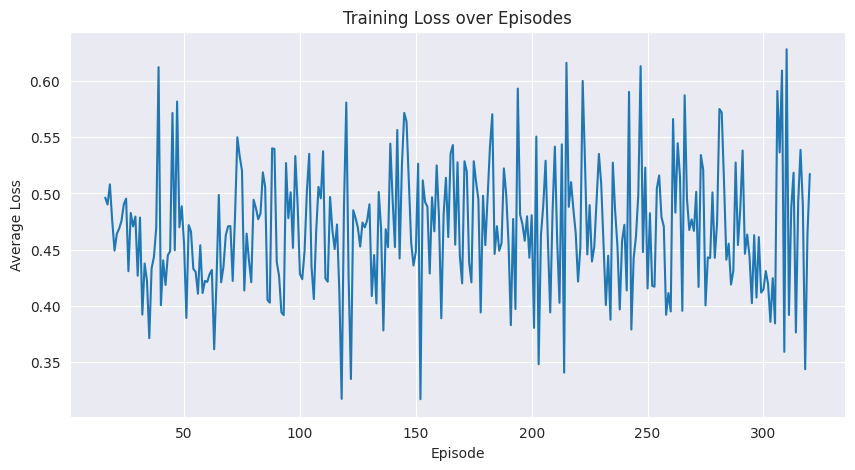

In [19]:
# Cell 11: (Thay thế Cell 10 cũ)
plt.figure(figsize=(10, 5))
plt.plot(range(batch_size, num_episodes + 1), losses)
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.title('Training Loss over Episodes')
plt.show()


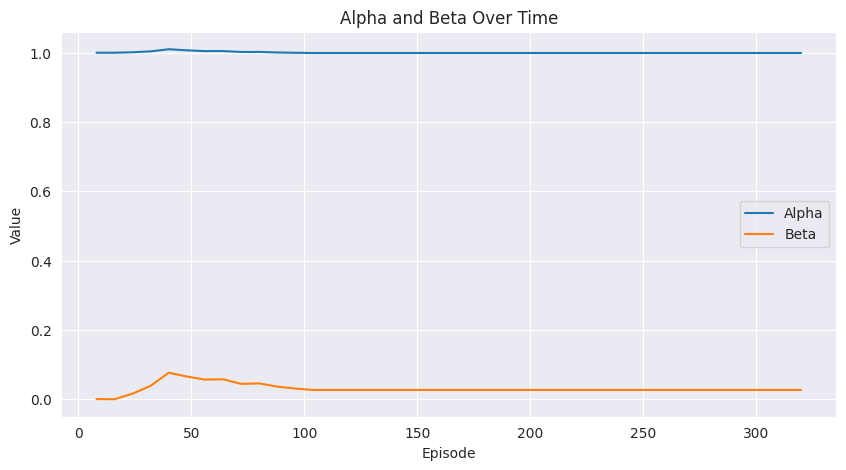

In [20]:
# Cell 12: (Thay thế Cell 11 cũ)
plt.figure(figsize=(10, 5))
plt.plot(episode_history, alpha_history, label='Alpha')
plt.plot(episode_history, beta_history, label='Beta')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Alpha and Beta Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Cell 13: (Thay thế Cell 12 cũ)
# Đánh giá model cuối cùng (wrapper model đã hiệu chỉnh)
print("\n--- Đánh giá Model sau khi hiệu chỉnh Bias ---")
evaluate_model(model, env, num_episodes=1000, device=device)


--- Đánh giá Model sau khi hiệu chỉnh Bias ---
Đang đánh giá trên device: cuda
Đang đánh giá... Kiến trúc Multi-Head (N=3 honeypots, M=9 nút)
--- Episode 50: Success ---
['Pad', 'Honeypot {Pad}']
Honeypots connected to: ['Web Server', 'Pad', 'New node']

--- Episode 100: Success ---
['New node', 'Honeypot {New node}']
Honeypots connected to: ['Web Server', 'Pad', 'New node']

Đã hoàn thành 100/1000 episodes...
--- Episode 150: Success ---
['New node', 'Honeypot {New node}']
Honeypots connected to: ['Web Server', 'Pad', 'New node']

--- Episode 200: Success ---
['Host 1', 'Web Server', 'Honeypot {Web Server}']
Honeypots connected to: ['Web Server', 'Pad', 'New node']

Đã hoàn thành 200/1000 episodes...
--- Episode 250: Success ---
['Web Server', 'Honeypot {Web Server}']
Honeypots connected to: ['Web Server', 'Pad', 'New node']

--- Episode 300: Success ---
['New node', 'Honeypot {New node}']
Honeypots connected to: ['Web Server', 'Pad', 'New node']

Đã hoàn thành 300/1000 episodes...
-